<img src="../../images/QISKit.gif" alt="Note: In order for images to show up in this jupyter notebook you need to select File => Trusted Notebook" width="250 px" align="left">

## _*Entanglement Revisited*_ 

The latest version of this notebook is available on https://github.com/QISKit/qiskit-tutorial.


***
### Contributors
Jay Gambetta, Antonio Córcoles, Anna Phan

## Entanglement

In [superposition and entanglement](superposition_and_entanglement.ipynb), we introduced you to the quantum concept of entanglement. We made the quantum state $|\psi\rangle= (|00\rangle+|11\rangle)/\sqrt{2}$ and showed that (accounting for experimental noise) the system has perfect correlations in both the computational and superposition bases. This means if $q_0$ is measured in state $|0\rangle$, we know $q_1$ is in the same state; likewise, if $q_0$ is measured in state $|+\rangle$, we know $q_1$ is also in the same state.

To understand the implications of this in more detail, we will look at the following topics in this notebook:
* [Two-Qubit Correlated Observables](#section1)
* [CHSH Inequality](#section2)
* [Two-, Three-, and Four-Qubit GHZ States](#section3)
* [Mermin's Test and the Three Box Game](#section4)


## Two-Qubit Correlated Observables<a id='section1'></a>

An observable is a Hermitian matrix where the real eigenvalues represent the outcome of the experiment, and the eigenvectors are the states to which the system is projected under measurement. That is, an observable $A$ is given by
  

$$  A = \sum_j a_j|a_j\rangle\langle a_j|$$ 

where $|a_j\rangle$ is the eigenvector of the observable with result $a_j$. The expectation value of this observable is given by 

$$\langle  A \rangle  = \sum_j a_j |\langle \psi  |a_j\rangle|^2  = \sum_j a_j \mathrm{Pr}(a_j|\psi).$$

We can see there is the standard relationship between average (expectation value) and probability. 

For a two-qubit system, the following are important two-outcome ($\pm1$) single-qubit observables:  

$$ Z= |0\rangle\langle 0| - |1\rangle\langle 1|$$ 
$$ X= |+\rangle\langle +| - |-\rangle\langle -|$$ 

These are also commonly referred to as the Pauli $Z$ and $X$ operators. These can be further extended to the two-qubit space to give 

$$\langle  I\otimes  Z\rangle =\mathrm{Pr}(00|\psi) - \mathrm{Pr}(01|\psi) +  \mathrm{Pr}(10|\psi)- \mathrm{Pr}(11|\psi)$$ 
$$\langle  Z\otimes  I\rangle =\mathrm{Pr}(00|\psi) + \mathrm{Pr}(01|\psi) -  \mathrm{Pr}(10|\psi)- \mathrm{Pr}(11|\psi)$$ 
$$\langle  Z\otimes  Z\rangle =\mathrm{Pr}(00|\psi) - \mathrm{Pr}(01|\psi) -  \mathrm{Pr}(10|\psi)+ \mathrm{Pr}(11|\psi)$$ 

$$\langle  I\otimes  X\rangle =\mathrm{Pr}(++|\psi) - \mathrm{Pr}(+-|\psi) +  \mathrm{Pr}(-+|\psi)- \mathrm{Pr}(--|\psi)$$ 
$$\langle  X\otimes  I\rangle =\mathrm{Pr}(++|\psi) + \mathrm{Pr}(+-|\psi) -  \mathrm{Pr}(-+|\psi)- \mathrm{Pr}(--|\psi)$$ 
$$\langle  X\otimes  X\rangle =\mathrm{Pr}(++|\psi) - \mathrm{Pr}(+-|\psi) -  \mathrm{Pr}(-+|\psi)+ \mathrm{Pr}(--|\psi)$$ 


$$\langle  Z\otimes  X\rangle =\mathrm{Pr}(0+|\psi) - \mathrm{Pr}(0-|\psi) -  \mathrm{Pr}(1+|\psi)+ \mathrm{Pr}(1-|\psi)$$ 
$$\langle  X\otimes  Z\rangle =\mathrm{Pr}(+0|\psi) - \mathrm{Pr}(+1|\psi) -  \mathrm{Pr}(-0|\psi)+ \mathrm{Pr}(-1|\psi)$$ 

In [1]:
# Imports
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

from qiskit import QuantumCircuit, QuantumProgram
from qiskit.backends import discover_local_backends, discover_remote_backends
from qiskit.tools.visualization import plot_histogram, circuit_drawer

In [2]:
# Connecting to the IBM Quantum Experience
import sys
try:
    sys.path.append("../../") # go to parent dir
    import Qconfig
    qx_config = {
        "APItoken": Qconfig.APItoken,
        "url": Qconfig.config['url']}
except:
    qx_config = {
        "APItoken":"YOUR_TOKEN_HERE",
        "url":"https://quantumexperience.ng.bluemix.net/api"}

from IBMQuantumExperience import IBMQuantumExperience
api = IBMQuantumExperience(token=qx_config['APItoken'], config={'url': qx_config['url']})

qp = QuantumProgram()
qp.set_api(qx_config['APItoken'], qx_config['url'])

In [62]:
# Finding the best device to run on
def lowest_pending_jobs(api):
    """Returns the online device with lowest pending jobs."""
    remote_backends = discover_remote_backends(api)
    remote_backends.remove('ibmqx_hpc_qasm_simulator')
    remote_backends.remove('ibmqx_qasm_simulator')
    remote_backends.remove('ibmqx5') # this can only run on ibmqx2 or ibmqx4
    device_status = [api.backend_status(backend) for backend in remote_backends]

    best = min([x for x in device_status if x['available'] is True],
               key=lambda x: x['pending_jobs'])
    return best['backend'] 

device_shots = 1024
device_name = lowest_pending_jobs(api)
device_config = qp.get_backend_configuration(device_name)
device_coupling = device_config['coupling_map']

print("the best backend is " + device_name + " with coupling " + str(device_coupling))

the best backend is ibmqx4 with coupling {1: [0], 2: [0, 1, 4], 3: [2, 4]}


Recall that to make the Bell state $|\psi\rangle= (|00\rangle+|11\rangle)/\sqrt{2}$ from the initial state $|00\rangle$, the quantum circuit first applies a Hadamard on $q_0$, followed by a CNOT from $q_0$ to $q_1$. On the IBM Q experience, this can done by using the script below to measure the above expectation values; we run four different experiments with measurements in the standard basis, superposition basis, and a combination of both.

In [4]:
QPS_SPECS = {
    'circuits': [{
        'name': 'bell',
        'quantum_registers': [{
            'name':'q',
            'size':2
        }],
        'classical_registers': [{
            'name':'c',
            'size':2
        }]}],
}

Q_program = QuantumProgram(specs=QPS_SPECS)
Q_program.set_api(Qconfig.APItoken, Qconfig.config['url'])

# quantum circuit to make Bell state 
bell = Q_program.get_circuit('bell')
q = Q_program.get_quantum_register('q')
c = Q_program.get_classical_register('c')

bell.h(q[0])
bell.cx(q[0],q[1])

# quantum circuit to measure q in standard basis 
measureZZ = Q_program.create_circuit('measureZZ', [q], [c])
measureZZ.measure(q[0], c[0])
measureZZ.measure(q[1], c[1])

# quantum circuit to measure q in superposition basis 
measureXX = Q_program.create_circuit('measureXX', [q], [c])
measureXX.h(q[0])
measureXX.h(q[1])
measureXX.measure(q[0], c[0])
measureXX.measure(q[1], c[1])

# quantum circuit to measure ZX
measureZX = Q_program.create_circuit('measureZX', [q], [c])
measureZX.h(q[0])
measureZX.measure(q[0], c[0])
measureZX.measure(q[1], c[1])

# quantum circuit to measure XZ
measureXZ = Q_program.create_circuit('measureXZ', [q], [c])
measureXZ.h(q[1])
measureXZ.measure(q[0], c[0])
measureXZ.measure(q[1], c[1])

Q_program.add_circuit('bell_measureZZ', bell+measureZZ )
Q_program.add_circuit('bell_measureXX', bell+measureXX )
Q_program.add_circuit('bell_measureZX', bell+measureZX )
Q_program.add_circuit('bell_measureXZ', bell+measureXZ )

circuits = ['bell_measureZZ', 'bell_measureZX', 'bell_measureXX', 'bell_measureXZ']

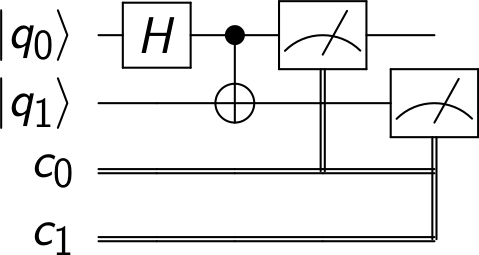

In [5]:
circuit_drawer(bell+measureZZ)

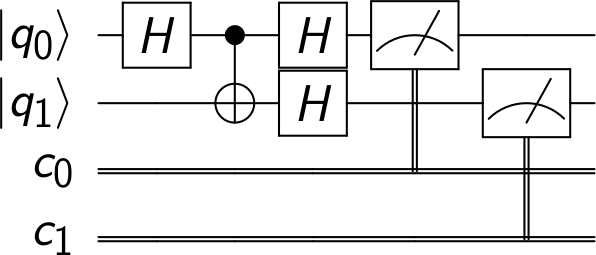

In [6]:
circuit_drawer(bell+measureXX)

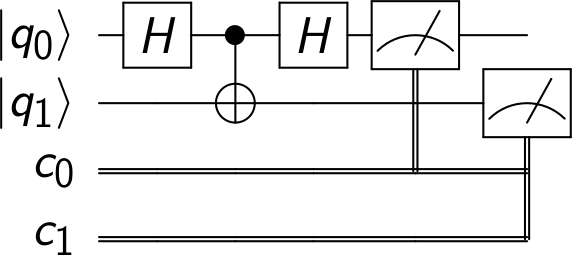

In [7]:
circuit_drawer(bell+measureZX)

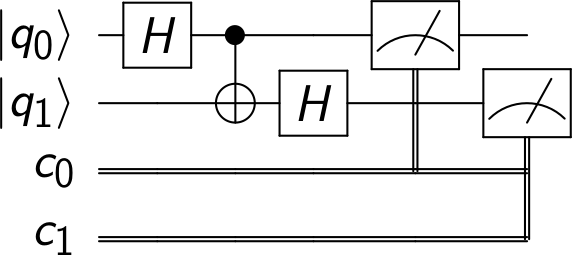

In [8]:
circuit_drawer(bell+measureXZ)

In [9]:
result = Q_program.execute(circuits, 
                           backend=device_name, coupling_map=device_coupling, shots=device_shots, 
                           max_credits=3, wait=10, timeout=300)

In [10]:
### THIS IS A KNOWN BUG AND WHEN WE FIX THE RETURN FROM THE REAL DEVICE WE WILL ONLY HAVE ONE SET OF OBSERVABLES

observable_first ={'00000': 1, '00001': -1, '00010': 1, '00011': -1}
observable_second ={'00000': 1, '00001': 1, '00010': -1, '00011': -1}
observable_correlated ={'00000': 1, '00001': -1, '00010': -1, '00011': 1}

observable_first_ideal ={'00': 1, '01': -1, '10': 1, '11': -1}
observable_second_ideal ={'00': 1, '01': 1, '10': -1, '11': -1}
observable_correlated_ideal ={'00': 1, '01': -1, '10': -1, '11': 1}

In [11]:
print('IZ = ' + str(result.average_data('bell_measureZZ',observable_first)))
print('ZI = ' + str(result.average_data('bell_measureZZ',observable_second)))
print('ZZ = ' + str(result.average_data('bell_measureZZ',observable_correlated)))

print('IX = ' + str(result.average_data('bell_measureXX',observable_first)))
print('XI = ' + str(result.average_data('bell_measureXX',observable_second)))
print('XX = ' + str(result.average_data('bell_measureXX',observable_correlated)))

print('ZX = ' + str(result.average_data('bell_measureZX',observable_correlated)))
print('XZ = ' + str(result.average_data('bell_measureXZ',observable_correlated)))

IZ = 0.0234375
ZI = 0.0390625
ZZ = 0.89453125
IX = 0.130859375
XI = 0.13671875
XX = 0.896484375
ZX = -0.037109375
XZ = 0.015625


Here we see that for the state $|\psi\rangle= (|00\rangle+|11\rangle)/\sqrt{2}$, expectation values (within experimental errors) are


Observable    | Expected value |Observable    | Expected value|Observable    | Expected value
------------- | -------------  | ------------- | ------------- | ------------- | -------------
ZZ  | 1   |XX  | 1  | ZX  | 0 
ZI  | 0   |XI  | 0  | XZ  | 0
IZ  | 0   |IX  | 0  |   |

How do we explain this situation? Here we introduce the concept of a *hidden variable model*. If we assume there is a hidden variable $\lambda$ and follow these two assumptions: 

* _Locality_: No information can travel faster than the speed of light. There is a hidden variable $\lambda$ that defines all the correlations so that  $$\langle A\otimes B\rangle = \sum_\lambda P(\lambda) A(\lambda) B(\lambda).$$ 
                      
* _Realism_: All observables have a definite value independent of the measurement ($A(\lambda)=\pm1$ etc.).

then can we describe these observations? --- The answer is yes! 

Assume $\lambda$ has two bits, each occurring randomly with probability 1/4. The following predefined table would then explain all the above observables:

$\lambda$    | Z (qubit 1) |Z (qubit 2)    | X (qubit 1)| X (qubit 2)   
------------- | -------------  | ------------- | ------------- | ------------- 
00  | 1 | 1 | 1 | 1  
01  | 1 | 1 |-1 |-1  
10  |-1 |-1 |-1 |-1    
11  |-1 |-1 | 1 | 1  

Thus, with a purely classical hidden variable model, we are able to reconcile the measured observations we had for this particular Bell state. However, there are some states for which this model will not hold. This was first observed by John Stewart Bell in 1964.  He proposed a theorem that suggests that there are no hidden variables in quantum mechanics. At the core of Bell's theorem is the famous Bell inequality. Here we'll use a refined version of this inequality (known as the CHSH inequality, derived by John Clauser, Michael Horne, Abner Shimony, and Richard Holt in 1969) to demonstrate Bell's proposal.

## CHSH Inequality <a id='section2'></a>


In the CHSH inequality, we measure the correlator of four observables: $A$ and $A'$ on $q_0$, and $B$ and $B'$ on $q_1$, which have eigenvalues $\pm 1$. The CHSH inequality says that no local hidden variable theory can have  

$$|C|>2$$ 

where 

$$C = \langle B\otimes A\rangle + \langle B\otimes A'\rangle+\langle B'\otimes A'\rangle-\langle B'\otimes A\rangle.$$

What would this look like with some hidden variable model under the locality and realism assumptions from above? $C$ then becomes 

$$C = \sum_\lambda P(\lambda) \{ B(\lambda) [ A(\lambda)+A'(\lambda)] + B'(\lambda) [ A'(\lambda)-A(\lambda)]$$
                      
and $[A(\lambda)+A'(\lambda)]=2$ (or 0) while $[A'(\lambda)-A(\lambda)]=0$ (or 2) respectively. That is, $|C|=2$, and noise will only make this smaller. 
 
If we measure a number greater than 2, the above assumptions cannot be valid. (This is a perfect example of one of those astonishing counterintuitive ideas one must accept in the quantum world.) For simplicity, we choose these observables to be 

 $$C = \langle Z\otimes Z\rangle + \langle Z\otimes X\rangle+\langle X\otimes X\rangle-\langle X\otimes Z\rangle.$$

$Z$ is measured in the computational basis, and $X$ in the superposition basis ($H$ is applied before measurement). The input state $$|\psi(\theta)\rangle = I\otimes Y(\theta)\frac{|00\rangle + |11\rangle}{\sqrt(2)} = \frac{\cos(\theta/2)|00\rangle + \cos(\theta/2)|11\rangle+\sin(\theta/2)|01\rangle-\sin(\theta/2)|10\rangle}{\sqrt{2}}$$ is swept vs. $\theta$ (think of this as allowing us to prepare a set of states varying in the angle $\theta$).
 
Note that the following demonstration of CHSH is not loophole-free. 

In [12]:
CHSH = lambda x : x[0]+x[1]+x[2]-x[3]

In [13]:
local_backend = 'local_qasm_simulator'
local_shots = 8192

program = []
xdata=[]

program_end = [measureZZ, measureZX, measureXX, measureXZ]

k = 0
for jj in range(30):
    theta = 2.0*np.pi*jj/30
    bell_middle = QuantumCircuit(q,c)
    bell_middle.ry(theta,q[0])
    for i in range(4):
        program.append('circuit'+str(k))
        Q_program.add_circuit('circuit'+str(k), bell+bell_middle+program_end[i] )
        k += 1
        
    xdata.append(theta)

In [14]:
result = Q_program.execute(program, backend=local_backend, shots=local_shots, max_credits=3, wait=10, timeout=240)

In [15]:
CHSH_data_sim = []
k = 0
for j in range(len(xdata)):
    temp=[]
    for i in range(4): 
        temp.append(result.average_data('circuit'+str(k),observable_correlated_ideal))
        k += 1
    CHSH_data_sim.append(CHSH(temp))

In [16]:
program_real = []
xdata_real=[]

k = 0
for jj in range(10):
    theta = 2.0*np.pi*jj/10
    bell_middle = QuantumCircuit(q,c)
    bell_middle.ry(theta,q[0])
    for i in range(4):
        program_real.append('circuit_real'+str(k))
        Q_program.add_circuit('circuit_real'+str(k), bell+bell_middle+program_end[i] )
        k += 1
        
    xdata_real.append(theta)

In [17]:
resultreal = Q_program.execute(program_real, 
                               backend=device_name, coupling_map=device_coupling, shots=device_shots, 
                               max_credits=3, wait=10, timeout=300)

In [18]:
CHSH_data_real = []
k = 0
for j in range(len(xdata_real)):
    temp=[]
    for i in range(4): 
        temp.append(resultreal.average_data('circuit_real'+str(k),observable_correlated))
        k += 1
    CHSH_data_real.append(CHSH(temp))

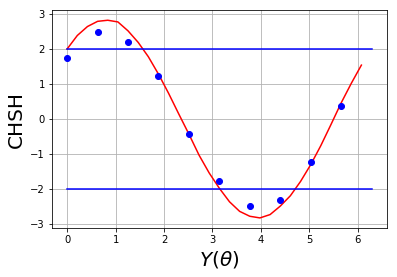

In [19]:
plt.plot(xdata, CHSH_data_sim, 'r-', xdata_real, CHSH_data_real, 'bo')
plt.plot([0, 2*np.pi], [2, 2], 'b-')
plt.plot([0, 2*np.pi], [-2, -2], 'b-')
plt.grid()
plt.ylabel('CHSH', fontsize=20)
plt.xlabel(r'$Y(\theta)$', fontsize=20)
plt.show()

The resulting graph created by running the previous cell compares the simulated data (sinusoidal line) and the data from the real experiment. The graph also gives lines at $\pm 2$ for reference. Did you violate the hidden variable model?

Here is the saved CHSH data. 

In [20]:
print(CHSH_data_real)

[1.748046875, 2.470703125, 2.19921875, 1.2109375, -0.423828125, -1.78515625, -2.490234375, -2.3359375, -1.240234375, 0.3515625]


Despite the presence of loopholes in our demonstration, we can see that this experiment is compatible with quantum mechanics as a theory with no local hidden variables. See the original experimental demonstrations of this test with superconducting qubits [here](https://arstechnica.com/science/2017/05/quantum-volume-one-number-to-benchmark-a-quantum-computer/) and [here](https://journals.aps.org/pra/abstract/10.1103/PhysRevA.81.062325).

## Two-, Three-, and Four-Qubit GHZ States<a id='section3'></a>

What does entanglement look like beyond two qubits? An important set of maximally entangled states are known as GHZ states (named after Greenberger, Horne, and Zeilinger). These are the states of the form 

$|\psi\rangle = \left (|0...0\rangle+|1...1\rangle\right)/\sqrt{2}$. The Bell state previously described is merely a two-qubit version of a GHZ state. The next cells prepare GHZ states of two, three, and four qubits. 

In [21]:
device_shots = 8192 # need more statistics for 3 and 4 qubit experiments

In [22]:
# 2 - qubits 

# quantum circuit to make GHZ state
q = Q_program.create_quantum_register('q', 2)
c = Q_program.create_classical_register('c', 2)
ghz = Q_program.create_circuit('ghz', [q], [c])
ghz.h(q[0])
ghz.cx(q[0],q[1])

# quantum circuit to measure q in standard basis 
measureZZ = Q_program.create_circuit('measureZZ', [q], [c])
measureZZ.measure(q[0], c[0])
measureZZ.measure(q[1], c[1])

measureXX = Q_program.create_circuit('measureXX', [q], [c])
measureXX.h(q[0])
measureXX.h(q[1])
measureXX.measure(q[0], c[0])
measureXX.measure(q[1], c[1])

Q_program.add_circuit('ghz_measureZZ', ghz+measureZZ )
Q_program.add_circuit('ghz_measureXX', ghz+measureXX )
circuits = ['ghz_measureZZ', 'ghz_measureXX']

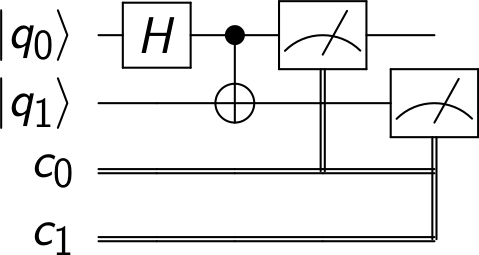

In [23]:
circuit_drawer(ghz+measureZZ)

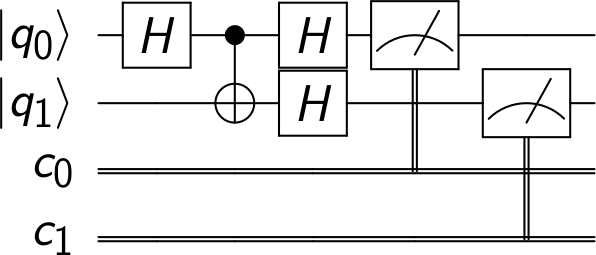

In [24]:
circuit_drawer(ghz+measureXX)

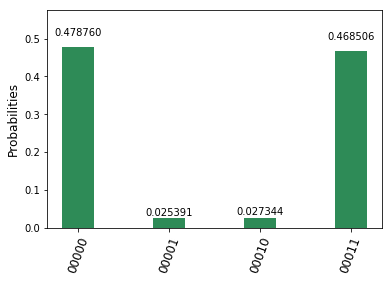

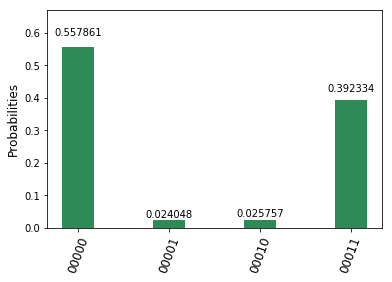

In [25]:
result2 = Q_program.execute(circuits, 
                            backend=device_name, coupling_map=device_coupling, shots=device_shots, 
                            max_credits=5, wait=10, timeout=600)

plot_histogram(result2.get_counts('ghz_measureZZ'))
plot_histogram(result2.get_counts('ghz_measureXX'))

In [26]:
# 3 - qubits 

# quantum circuit to make GHZ state 
q3 = Q_program.create_quantum_register('q3', 3)
c3 = Q_program.create_classical_register('c3', 3)
ghz = Q_program.create_circuit('ghz', [q3], [c3])
ghz.h(q3[0])
ghz.cx(q3[0],q3[1])
ghz.cx(q3[1],q3[2])

# quantum circuit to measure q in standard basis 
measureZZZ = Q_program.create_circuit('measureZZZ', [q3], [c3])
measureZZZ.measure(q3[0], c3[0])
measureZZZ.measure(q3[1], c3[1])
measureZZZ.measure(q3[2], c3[2])

measureXXX = Q_program.create_circuit('measureXXX', [q3], [c3])
measureXXX.h(q3[0])
measureXXX.h(q3[1])
measureXXX.h(q3[2])
measureXXX.measure(q3[0], c3[0])
measureXXX.measure(q3[1], c3[1])
measureXXX.measure(q3[2], c3[2])

Q_program.add_circuit('ghz_measureZZZ', ghz+measureZZZ )
Q_program.add_circuit('ghz_measureXXX', ghz+measureXXX )
circuits = ['ghz_measureZZZ', 'ghz_measureXXX']

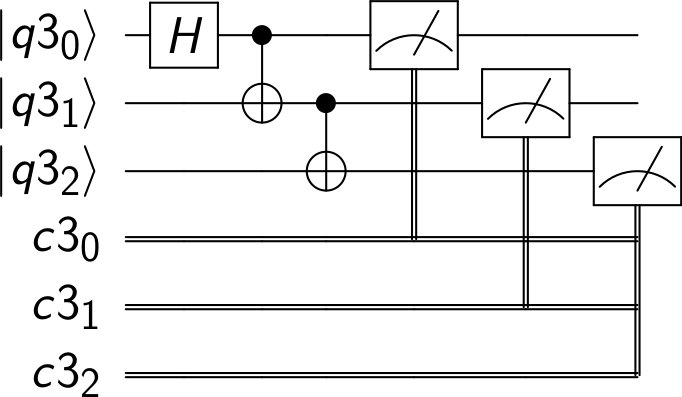

In [27]:
circuit_drawer(ghz+measureZZZ)

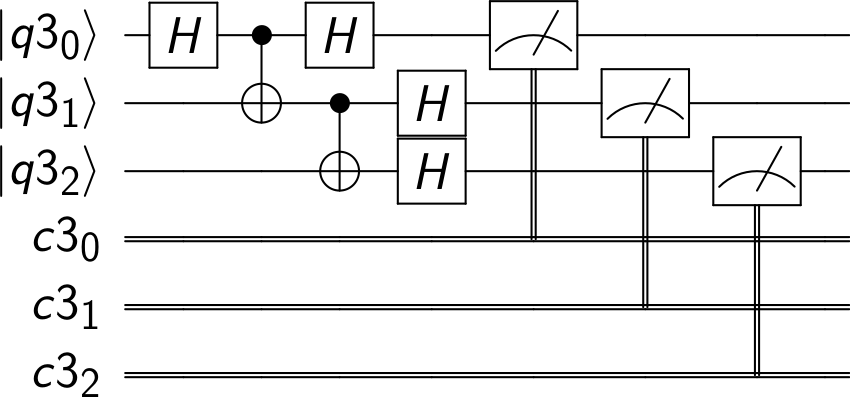

In [28]:
circuit_drawer(ghz+measureXXX)

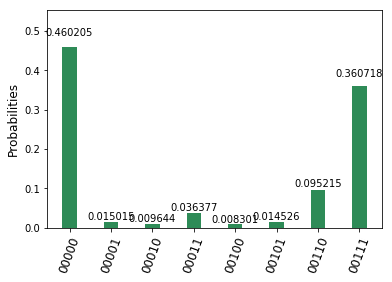

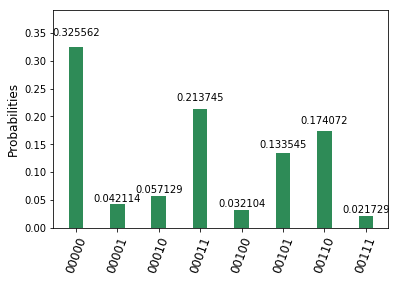

In [31]:
result3 = Q_program.execute(circuits, 
                            backend=device_name, coupling_map=device_coupling, shots=device_shots, 
                            max_credits=5, wait=10, timeout=600)
plot_histogram(result3.get_counts('ghz_measureZZZ'))
plot_histogram(result3.get_counts('ghz_measureXXX'))

In [32]:
# 4 - qubits 
shots = 8192
# quantum circuit to make GHZ state 
q4 = Q_program.create_quantum_register('q4', 4)
c4 = Q_program.create_classical_register('c4', 4)
ghz = Q_program.create_circuit('ghz', [q4], [c4])
ghz.h(q4[0])
ghz.cx(q4[0],q4[1])
ghz.cx(q4[1],q4[2])
ghz.h(q4[3])
ghz.h(q4[2])
ghz.cx(q4[3],q4[2])
ghz.h(q4[3])
ghz.h(q4[2])

# quantum circuit to measure q in standard basis 
measureZZZZ = Q_program.create_circuit('measureZZZZ', [q4], [c4])
measureZZZZ.measure(q4[0], c4[0])
measureZZZZ.measure(q4[1], c4[1])
measureZZZZ.measure(q4[2], c4[2])
measureZZZZ.measure(q4[3], c4[3])

measureXXXX = Q_program.create_circuit('measureXXXX', [q4], [c4])
measureXXXX.h(q4[0])
measureXXXX.h(q4[1])
measureXXXX.h(q4[2])
measureXXXX.h(q4[3])
measureXXXX.measure(q4[0], c4[0])
measureXXXX.measure(q4[1], c4[1])
measureXXXX.measure(q4[2], c4[2])
measureXXXX.measure(q4[3], c4[3])

Q_program.add_circuit('ghz_measureZZZZ', ghz+measureZZZZ )
Q_program.add_circuit('ghz_measureXXXX', ghz+measureXXXX )
circuits = ['ghz_measureZZZZ', 'ghz_measureXXXX']

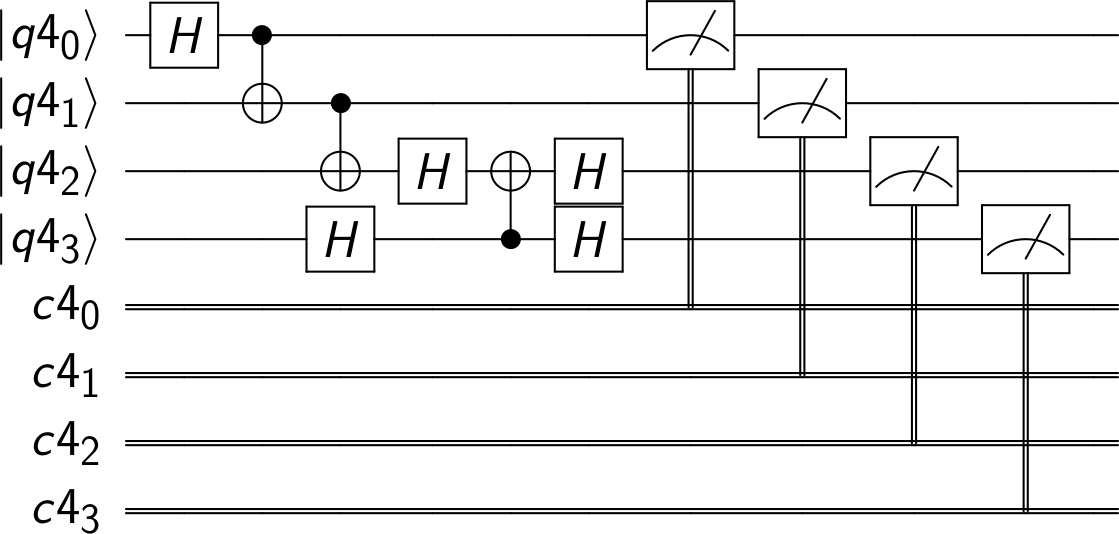

In [33]:
circuit_drawer(ghz+measureZZZZ)

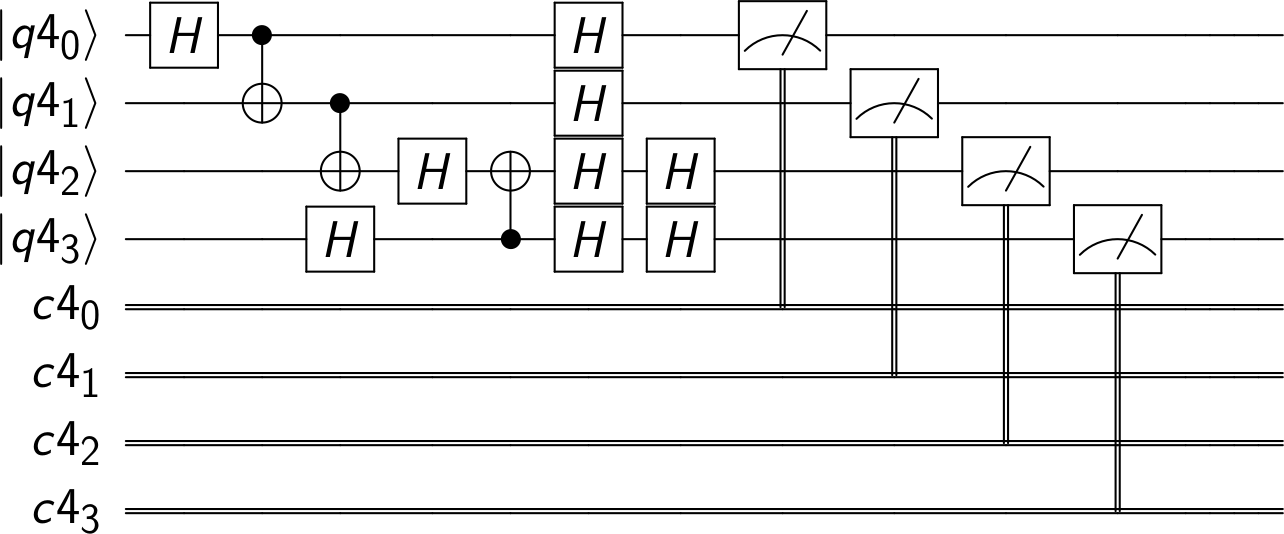

In [34]:
circuit_drawer(ghz+measureXXXX)

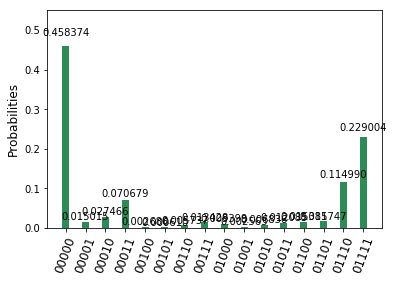

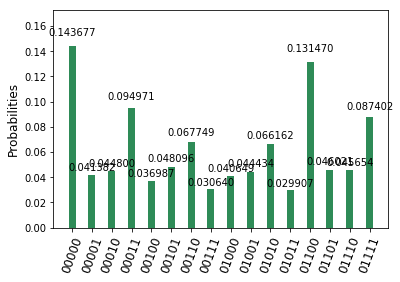

In [35]:
result4 = Q_program.execute(circuits, 
                            backend=device_name, coupling_map=device_coupling, shots=device_shots, 
                            max_credits=5, wait=10, timeout=600)
plot_histogram(result4.get_counts('ghz_measureZZZZ'))
plot_histogram(result4.get_counts('ghz_measureXXXX'))

## Mermin's Test and the Three Box Game<a id='section4'></a>
In case the violation of Bell's inequality (CHSH) by two qubits is not enough to convince you to believe in quantum mechanics, we can generalize to a more stringent set of tests with three qubits, which can give a single-shot violation (rather than taking averaged statistics). A well-known three-qubit case is Mermin's inequality, which is a test we can perform on GHZ states. 

An example of a three-qubit GHZ state is $|\psi\rangle = \left (|000\rangle+|111\rangle\right)/\sqrt{2}$. You can see this is a further generalization of a Bell state and, if measured, should give $|000\rangle$ half the time and $|111 \rangle$ the other half of the time.

In [36]:
# quantum circuit to make GHZ state 
q3 = Q_program.create_quantum_register('q3', 3)
c3 = Q_program.create_classical_register('c3', 3)
ghz = Q_program.create_circuit('ghz', [q3], [c3])
ghz.h(q3[0])
ghz.cx(q3[0],q3[1])
ghz.cx(q3[0],q3[2])

# quantum circuit to measure q in standard basis 
measureZZZ = Q_program.create_circuit('measureZZZ', [q3], [c3])
measureZZZ.measure(q3[0], c3[0])
measureZZZ.measure(q3[1], c3[1])
measureZZZ.measure(q3[2], c3[2])

Q_program.add_circuit('ghz_measureZZZ', ghz+measureZZZ )
circuits = ['ghz_measureZZZ']

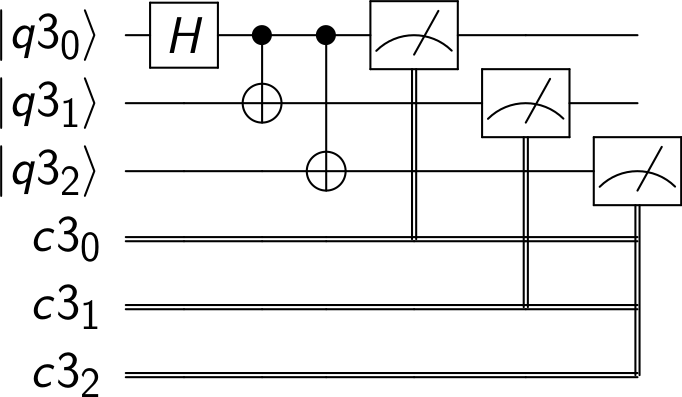

In [37]:
circuit_drawer(ghz+measureZZZ)

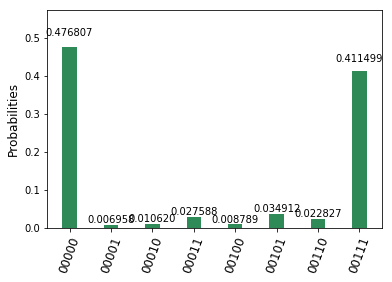

In [39]:
result5 = Q_program.execute(circuits, 
                            backend=device_name, coupling_map=device_coupling, shots=device_shots, 
                            max_credits=5, wait=10, timeout=600)
plot_histogram(result5.get_counts('ghz_measureZZZ'))

Suppose we have three independent systems, $\{A, B, C\}$, for which we can query two particular questions (observables) $X$ and $Y$. In each case, either query can give $+1$ or $-1$. Consider whether it is possible to choose some state of the three boxes, such that we can satisfy the following four conditions: $X_A Y_B Y_C = 1$, $Y_A X_B Y_C =1$, $Y_A Y_B X_C = 1$, and $X_A X_B X_C = -1$. Classically, this can be shown to be impossible... but a three-qubit GHZ state can in fact satisfy all four conditions.

In [40]:
MerminM = lambda x : x[0]*x[1]*x[2]*x[3]

In [41]:
observable ={'00000': 1, '00001': -1, '00010': -1, '00011': 1, '00100': -1, '00101': 1, '00110': 1, '00111': -1}

In [42]:
# quantum circuit to measure q XXX 
measureXXX = Q_program.create_circuit('measureXXX', [q3], [c3])
measureXXX.h(q3[0])
measureXXX.h(q3[1])
measureXXX.h(q3[2])
measureXXX.measure(q3[0], c3[0])
measureXXX.measure(q3[1], c3[1])
measureXXX.measure(q3[2], c3[2])

# quantum circuit to measure q XYY
measureXYY = Q_program.create_circuit('measureXYY', [q3], [c3])
measureXYY.s(q3[1]).inverse()
measureXYY.s(q3[2]).inverse()
measureXYY.h(q3[0])
measureXYY.h(q3[1])
measureXYY.h(q3[2])
measureXYY.measure(q3[0], c3[0])
measureXYY.measure(q3[1], c3[1])
measureXYY.measure(q3[2], c3[2])

# quantum circuit to measure q YXY
measureYXY = Q_program.create_circuit('measureYXY', [q3], [c3])
measureYXY.s(q3[0]).inverse()
measureYXY.s(q3[2]).inverse()
measureYXY.h(q3[0])
measureYXY.h(q3[1])
measureYXY.h(q3[2])
measureYXY.measure(q3[0], c3[0])
measureYXY.measure(q3[1], c3[1])
measureYXY.measure(q3[2], c3[2])

# quantum circuit to measure q YYX
measureYYX = Q_program.create_circuit('measureYYX', [q3], [c3])
measureYYX.s(q3[0]).inverse()
measureYYX.s(q3[1]).inverse()
measureYYX.h(q3[0])
measureYYX.h(q3[1])
measureYYX.h(q3[2])
measureYYX.measure(q3[0], c3[0])
measureYYX.measure(q3[1], c3[1])
measureYYX.measure(q3[2], c3[2])

Q_program.add_circuit('ghz_measureXXX', ghz+measureXXX )
Q_program.add_circuit('ghz_measureYYX', ghz+measureYYX )
Q_program.add_circuit('ghz_measureYXY', ghz+measureYXY )
Q_program.add_circuit('ghz_measureXYY', ghz+measureXYY )

circuits = ['ghz_measureXXX', 'ghz_measureYYX', 'ghz_measureYXY', 'ghz_measureXYY']

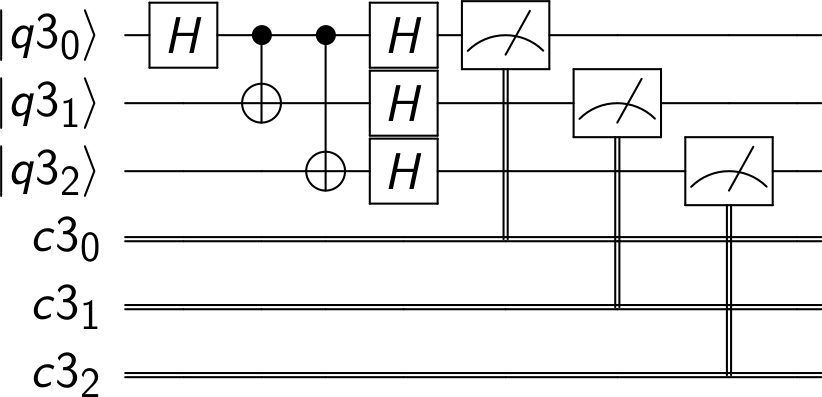

In [43]:
circuit_drawer(ghz+measureXXX)

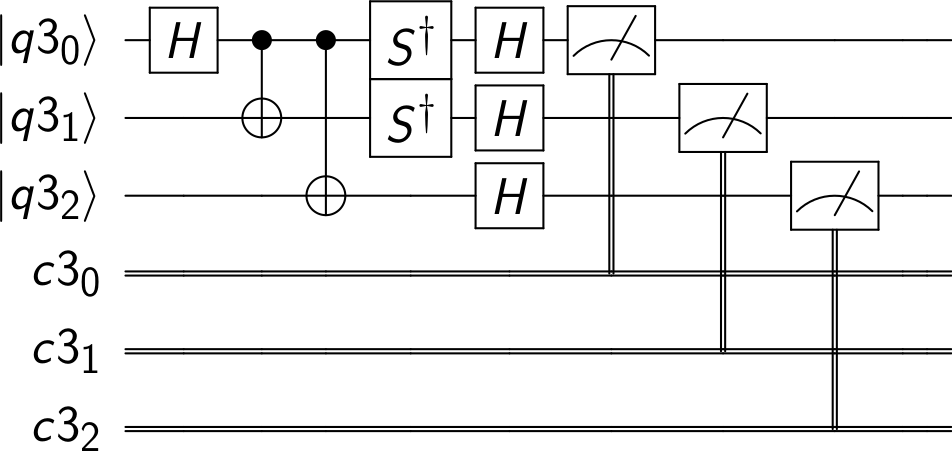

In [44]:
circuit_drawer(ghz+measureYYX)

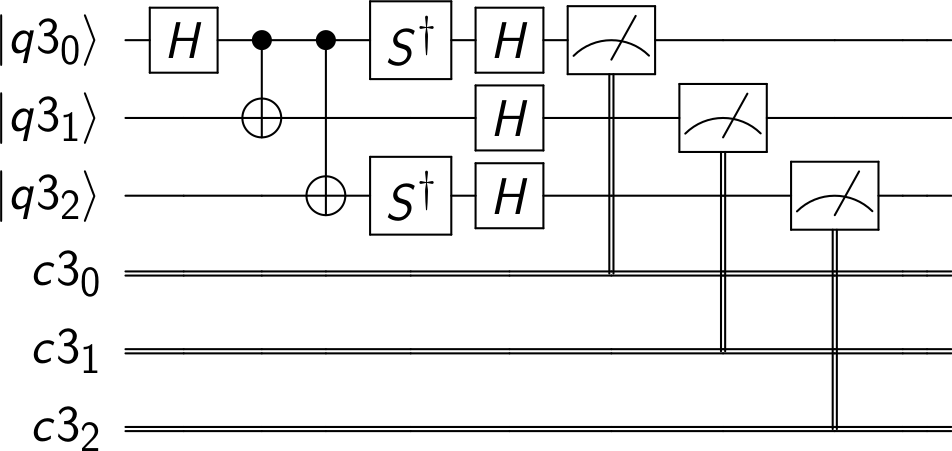

In [45]:
circuit_drawer(ghz+measureYXY)

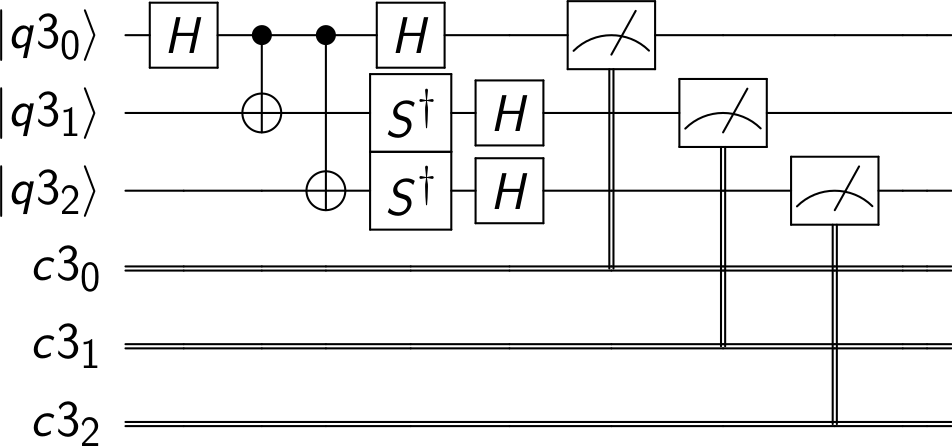

In [46]:
circuit_drawer(ghz+measureXYY)

In [63]:
result6 = Q_program.execute(circuits, 
                            backend=device_name, coupling_map=device_coupling, shots=device_shots, 
                            max_credits=5, wait=10, timeout=600)

In [64]:
temp=[]
temp.append(result6.average_data('ghz_measureXXX',observable))
temp.append(result6.average_data('ghz_measureYYX',observable))
temp.append(result6.average_data('ghz_measureYXY',observable))
temp.append(result6.average_data('ghz_measureXYY',observable))
print(MerminM(temp))

-0.07755589974112809


The above shows that the average statistics are not consistent with a local hidden variable theory. To demonstrate with single shots, we can run 50 single experiments, with each experiment chosen randomly, and the outcomes saved. If there was a local hidden variable theory, all the outcomes would be $+1$.

In [1]:
%run "../../version.ipynb"

Package,Version
QISKit,0.4.10
IBMQuantumExperience,>= 1.8.26
numpy,">= 1.13, < 1.14"
scipy,">= 0.19, < 0.20"
matplotlib,">= 2.0, < 2.1"
